## Todo

- comparar leitos cnes com leitos api, ver se está muito fora
- medidas de desatualização por estado e tipo de gestão

In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime, timezone, timedelta
import time
import glob
import gzip
import requests

In [2]:
# # dt_run = datetime.datetime.strptime('2021-02-18', '%Y-%m-%d')
# dt_run = datetime.now(timezone.utc) # UTC time
# print(dt_run)

## Ler dados

In [17]:
DATA_FOLDER = 'data/leitos/'

In [18]:
# data_files = glob.glob(f'{DATA_FOLDER}data_*.json.gz')
data_files = glob.glob(f'{DATA_FOLDER}data_*.csv.gz')
data_files.sort(reverse=True)
DATA_FILE = data_files[0]
print(DATA_FILE)

data/leitos/data_2021-03-09.csv.gz


In [19]:
# with gzip.open(DATA_FILE, 'r') as fin:
#     data = json.loads(fin.read().decode('utf-8'))
    
#     hits = data['hits']['hits']
#     df = pd.json_normalize(hits)

#     print(df.columns.values)
#     df.columns = [x.replace('_source.', '') for x in df.columns.values]

#     df.head()

In [20]:
# TS_RUN = pd.to_datetime(data['ts_run'])

NameError: name 'data' is not defined

In [7]:
df = pd.read_csv(DATA_FILE)

In [21]:
TS_RUN = pd.to_datetime(df.iloc[0]['ts_run'])

In [22]:
df.columns.values

array(['_index', '_type', '_id', '_score', 'estado', 'estadoSigla',
       'municipio', 'cnes', 'nomeCnes', 'dataNotificacaoOcupacao',
       'ofertaRespiradores', 'ofertaHospCli', 'ofertaHospUti',
       'ofertaSRAGCli', 'ofertaSRAGUti', 'ocupHospCli', 'ocupHospUti',
       'ocupSRAGCli', 'ocupSRAGUti', 'altas', 'obitos',
       'ocupacaoInformada', 'algumaOcupacaoInformada', 'ts_run',
       'totalOfertaCli', 'totalOfertaUti', 'totalOcupCli', 'totalOcupUti',
       'totalOfertaCliAlt', 'totalOfertaUtiAlt', 'has_uti_proxy'],
      dtype=object)

## Limpar e criar features

In [23]:
df = df.fillna({
    'ofertaHospCli': 0,
    'ofertaSRAGCli': 0,
    'ofertaHospUti': 0,
    'ofertaSRAGUti': 0,
    'ocupHospCli': 0,
    'ocupSRAGCli': 0,
    'ocupHospUti': 0,
    'ocupSRAGUti': 0,
})

### Considerando oferta sem ocupação

In [24]:
df['totalOfertaCli'] = df['ofertaHospCli'] + df['ofertaSRAGCli']
df['totalOfertaUti'] = df['ofertaHospUti'] + df['ofertaSRAGUti']
df['totalOcupCli'] = df['ocupHospCli'] + df['ocupSRAGCli']
df['totalOcupUti'] = df['ocupHospUti'] + df['ocupSRAGUti']

### Considerando oferta como oferta + ocupação

In [25]:
df['totalOfertaCliAlt'] = df['ofertaHospCli'] + df['ofertaSRAGCli'] + df['ocupHospCli'] + df['ocupSRAGCli']
df['totalOfertaUtiAlt'] = df['ofertaHospUti'] + df['ofertaSRAGUti'] + df['ocupHospUti'] + df['ocupSRAGUti']

### Tem UTI

- Tem alguma vaga ou ocupação de UTI, Hosp ou SRAG

In [26]:
df['has_uti_proxy'] = np.where(df['totalOfertaUtiAlt'] > 0, True, False)

### Colunas de tempo

In [27]:
df['dataNotificacaoOcupacao'] = pd.to_datetime(df['dataNotificacaoOcupacao'])

In [28]:
UPDATED_DAYS = [7, 14, 90]
for d in UPDATED_DAYS:
    df[f'updated_{str(d)}d'] = np.where(df['dataNotificacaoOcupacao'] >= TS_RUN - timedelta(days=d), True, False)

In [29]:
for d in UPDATED_DAYS:
    pct_outdated = len(df[df[f'updated_{str(d)}d'] == True]) / len(df)
    print(f'{round(pct_outdated * 100, 1)}% updated in {str(d)} days')

64.6% updated in 7 days
66.8% updated in 14 days
75.0% updated in 90 days


In [30]:
df[df['updated_90d'] == False].head()

,_index,_type,_id,_score,estado,estadoSigla,municipio,cnes,nomeCnes,dataNotificacaoOcupacao,...,totalOfertaCli,totalOfertaUti,totalOcupCli,totalOcupUti,totalOfertaCliAlt,totalOfertaUtiAlt,has_uti_proxy,updated_7d,updated_14d,updated_90d
8,leito_ocupacao,_doc,228753,1.0,Ceará,ce,Pacatuba,228753,NaN,2020-09-04 10:58:51.200000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
34,leito_ocupacao,_doc,2712016,1.0,Pernambuco,PE,Sertânia,2712016,HOSPITAL MARIA ALICE GOMES LAFAYETTE,2020-11-27 03:00:19.869000+00:00,...,72.0,0.0,10.0,0.0,82.0,0.0,False,False,False,False
35,leito_ocupacao,_doc,0116335,1.0,Pará,PA,Marabá,0116335,HOSPITAL DE CAMPANHA COVID 19 MARABA,2020-11-26 03:00:19.985000+00:00,...,169.0,31.0,3.0,0.0,172.0,31.0,True,False,False,False
36,leito_ocupacao,_doc,12769,1.0,Rio de Janeiro,rj,Niterói,12769,NaN,2020-10-18 03:00:09.902000+00:00,...,0.0,0.0,20.0,7.0,20.0,7.0,True,False,False,False
37,leito_ocupacao,_doc,2547317,1.0,Espírito Santo,ES,São José do Calçado,2547317,HOSPITAL SAO JOSE,2020-10-18 03:00:12.938000+00:00,...,66.0,10.0,26.0,8.0,92.0,18.0,True,False,False,False


### Consulta CNES

In [31]:
STANDARD_HEADERS = {
    'Connection': 'keep-alive',
    'Pragma': 'no-cache',
    'Cache-Control': 'no-cache',
    'Accept': 'application/json, text/plain, */*',
    'Referer': 'http://cnes.datasus.gov.br/pages/estabelecimentos/consulta.jsp',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36',
}

In [32]:
def get_basic_info_by_cnes(cnes):
    params = (
        ('cnes', cnes),
    )
    r = requests.get('http://cnes.datasus.gov.br/services/estabelecimentos', headers=STANDARD_HEADERS, params=params, verify=False)
    return json.loads(r.content)

In [33]:
def get_detailed_info(id):
    r = requests.get(f'http://cnes.datasus.gov.br/services/estabelecimentos/{id}', headers=STANDARD_HEADERS, verify=False)
    return json.loads(r.content)

In [34]:
def get_beds(id):
    r = requests.get(f'http://cnes.datasus.gov.br/services/estabelecimentos-hospitalar/{id}', headers=STANDARD_HEADERS, verify=False)
    return json.loads(r.content)

In [35]:
def check_if_deactivated(id):
    # returns True is deactivated, false otherwise
    r = requests.get(f'http://cnes.datasus.gov.br/services/estabelecimentos-desativados-local/validar/{id}', headers=STANDARD_HEADERS, verify=False)
    return json.loads(r.content)['existe']

In [36]:
def get_all_info(cnes):
    basic_info = get_basic_info_by_cnes(cnes)
    # display(basic_info)
    first_match = basic_info[0]
    id = str(first_match['id'])

    beds = get_beds(id)
    detailed_info = get_detailed_info(id)
    deactivated = check_if_deactivated(id)
    
    detailed_info['beds'] = beds
    detailed_info['deactivated'] = deactivated
    return detailed_info

In [37]:
def get_all_hospital_data(df):
    ts_run = datetime.now(timezone.utc)
    cnes_codes = df[:].cnes.unique()
    counter = 1
    errors = []
    start_time = time.time()
    end_time = time.time()

    for cnes in cnes_codes:
        print(cnes, f'{counter}/{len(cnes_codes)}')
        try:
            info = get_all_info(cnes)
            info['ts_run'] = ts_run.isoformat()
            info['error'] = False
            with open(f'data/hospitais/{cnes}.json', 'w') as outfile:
                json.dump(info, outfile)
        except Exception as e:
            print('error:', e)
            errors.append(cnes)
            with open(f'data/hospitais/{cnes}.json', 'w') as outfile:
                json.dump({'cnes': cnes, 'error': True}, outfile)
        finally:
            counter += 1

    time_elapsed = (end_time - start_time)
    print(time_elapsed)
    return errors

### Fazer consultas

In [38]:
# errors = get_all_hospital_data(df)
# with open(f'data/hospitais_errors.json', 'w') as outfile:
#     json.dump(errors, outfile)

In [39]:
print('% with invalid CNES name', len(df[(df.nomeCnes.isna())]) / len(df))

% with invalid CNES name 0.12901540872290415


In [40]:
print('% with invalid CNES name AND updated last 14 days', len(df[(df.nomeCnes.isna()) & (df.updated_14d == True)]) / len(df))

% with invalid CNES name AND updated last 14 days 0.03499608252807521


In [41]:
cnes_files = glob.glob('data/hospitais/*.json')

frames = []
for file_path in cnes_files:
    with open(file_path) as f:
        data = json.load(f)
    if data['error'] == False:
        frames.append(pd.json_normalize(data))

df_hosp = pd.concat(frames)

In [42]:
# salvar
# df_hosp.to_csv('exports/hospitais_cnes.csv', index=False)

In [43]:
df_hosp.head()

,id,cnes,noFantasia,noEmpresarial,natJuridica,natJuridicaMant,cnpj,tpPessoa,nvDependencia,nuAlvara,...,dsMotivoDesab,cpfDiretorCln,nuCompDesab,dtCarga,dtAtualizacaoOrigem,dtAtualizacao,beds,deactivated,ts_run,error
0,2929909383298,9383298,HOSPITAL REGIONAL DA CHAPADA,BAHIA SECRETARIA DE SAUDE DO ESTADO,1,1,None,3,3,None,...,None,82902623534,None,28/02/2021,03/12/2017,25/02/2021,"[{'dsAtributo': 'COMPLEMENTAR', 'coLeito': '75...",False,2021-03-03T18:25:14.012835+00:00,False
0,5107002397684,2397684,HOSPITAL E MATERNIDADE SAO JOAO BATISTA,SOCIEDADE HOSPITALAR SAO JOAO BATISTA,3,None,03128118000198,3,1,58632909/2020,...,None,05626030263,None,24/02/2021,03/06/2004,24/07/2020,"[{'dsAtributo': 'COMPLEMENTAR', 'coLeito': '66...",False,2021-03-03T18:25:14.012835+00:00,False
0,2612502344289,2344289,HOSPITAL MUNICIPAL RAYMUNDO FRANCELINO ARAGAO,PREFEITURA MUNICIPAL DE SANTA CRUZ DO CAPIBARIBE,1,1,None,3,3,None,...,None,08168838408,None,28/02/2021,30/10/2001,04/09/2020,"[{'dsAtributo': 'ESPEC - CIRURGICO', 'coLeito'...",False,2021-03-03T18:25:14.012835+00:00,False
0,3550305420938,5420938,HOSP MUN CARMEN PRUDENTE,PREFEITURA DO MUNICIPIO DE SAO PAULO,1,1,46392148004107,3,3,004552/2007 VS,...,None,01422554830,None,28/02/2021,29/06/2007,30/10/2020,"[{'dsAtributo': 'COMPLEMENTAR', 'coLeito': '93...",True,2021-03-03T18:25:14.012835+00:00,False
0,5300100010480,0010480,HOSPITAL REGIONAL DE CEILANDIA,HOSPITAL REGIONAL DE CEILANDIA,1,1,00394700001341,3,3,None,...,None,49350331187,None,02/03/2021,25/11/2002,01/03/2021,"[{'dsAtributo': 'COMPLEMENTAR', 'coLeito': '96...",False,2021-03-03T18:25:14.012835+00:00,False


In [44]:
deactivated_cnes = df_hosp[df_hosp.deactivated == True].cnes.tolist()
len(deactivated_cnes) / len(df_hosp)

0.039764771772612714

### Merge com dados da API

In [45]:
df_h = df.merge(df_hosp, on='cnes', suffixes=('', '_cnes'), how='left')

In [46]:
len(df_h[(df_h.deactivated == True) & (df_h.updated_14d == True)]) / len(df_h)

0.026638809088534866

In [47]:
len(df_h[(df_h.deactivated == True) & (df_h.updated_14d == False)]) / len(df_h)

0.010446591799425437

In [48]:
df_h.columns.values

array(['_index', '_type', '_id', '_score', 'estado', 'estadoSigla',
       'municipio', 'cnes', 'nomeCnes', 'dataNotificacaoOcupacao',
       'ofertaRespiradores', 'ofertaHospCli', 'ofertaHospUti',
       'ofertaSRAGCli', 'ofertaSRAGUti', 'ocupHospCli', 'ocupHospUti',
       'ocupSRAGCli', 'ocupSRAGUti', 'altas', 'obitos',
       'ocupacaoInformada', 'algumaOcupacaoInformada', 'ts_run',
       'totalOfertaCli', 'totalOfertaUti', 'totalOcupCli', 'totalOcupUti',
       'totalOfertaCliAlt', 'totalOfertaUtiAlt', 'has_uti_proxy',
       'updated_7d', 'updated_14d', 'updated_90d', 'id', 'noFantasia',
       'noEmpresarial', 'natJuridica', 'natJuridicaMant', 'cnpj',
       'tpPessoa', 'nvDependencia', 'nuAlvara', 'dtExpAlvara',
       'orgExpAlvara', 'dsTpUnidade', 'dsStpUnidade', 'noLogradouro',
       'nuEndereco', 'cep', 'regionalSaude', 'bairro', 'noComplemento',
       'municipio_cnes', 'noMunicipio', 'uf', 'tpGestao', 'nuTelefone',
       'tpSempreAberto', 'coMotivoDesab', 'dsMotivoDesa

In [49]:
print('% which could not find CNES data', len(df_h[df_h.id.isna()]) / len(df_h))

% which could not find CNES data 0.06738051710629407


In [50]:
print('% which could not find CNES data AND updated last 14d', len(df_h[(df_h.id.isna()) & (df_h.updated_14d == True)]) / len(df_h))

% which could not find CNES data AND updated last 14d 0.008879603029511622


In [51]:
print('% with CNES data AND NOT updated last 14d', len(df_h[(df_h.id.notna()) & (df_h.updated_14d == False)]) / len(df_h))

% with CNES data AND NOT updated last 14d 0.2734395403499608


### Tentando diferenciar os desativados

- Não tem dados CNES & não foram atualizados nos últimos 14 dias
- OU Tem dados CNES & CNES == 'desativado' & não foram atualizados nos últimos 14 dias

In [52]:
df_deactivated = (df_h[
    ((df_h.id.isna()) & (df_h.updated_14d == False))
    |
    ((df_h.id.notna()) & (df_h.deactivated == True) & (df_h.updated_14d == False))
])

In [53]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_h[df_h.cnes == '2160498'].iloc[0])

_index                                                        leito_ocupacao
_type                                                                   _doc
_id                                                                  2160498
_score                                                                     1
estado                                                          Minas Gerais
estadoSigla                                                               MG
municipio                                                           Iguatama
cnes                                                                 2160498
nomeCnes                                    HOSPITAL MUNICIPAL SAO FRANCISCO
dataNotificacaoOcupacao                     2020-07-03 20:57:31.521000+00:00
ofertaRespiradores                                                         0
ofertaHospCli                                                             16
ofertaHospUti                                                              0

In [54]:
len(df_deactivated) / len(df_h)

0.06894750587620789

In [55]:
df_h['deactivated_proxy'] = np.where(df_h._id.isin(df_deactivated._id.unique()), True, False)

In [56]:
len(df_h[df_h['deactivated_proxy'] == True]) / len(df_h) == len(df_deactivated) / len(df_h)

True

## Desatualizados por estado

<AxesSubplot:ylabel='estado'>

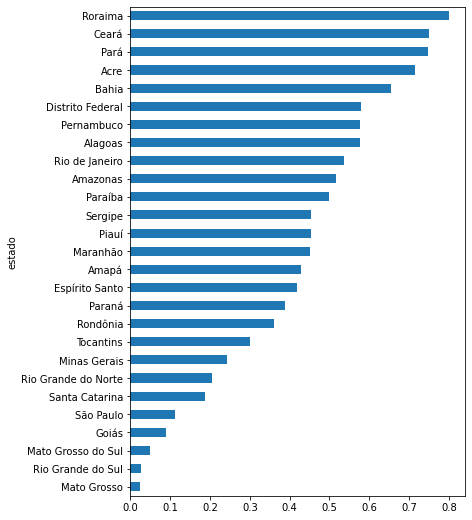

In [57]:
df_tmp = df_h[df_h['deactivated_proxy'] == False]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['estado']).size() 
         / df_tmp.groupby(['estado']).size()
).sort_values().plot.barh(figsize=(6,9))

In [58]:
len(df_h[df_h.has_uti_proxy == True]) / len(df_h)

0.4693131365891878

<AxesSubplot:ylabel='estado'>

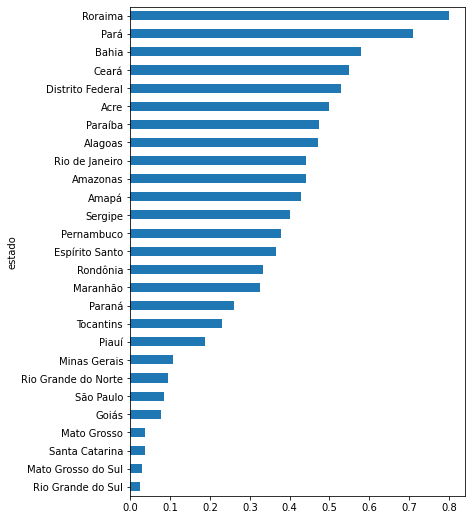

In [59]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True)]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['estado']).size() 
         / df_tmp.groupby(['estado']).size()
).sort_values().plot.barh(figsize=(6,9))

In [60]:
df_h.groupby(['tpGestao',]).size()

tpGestao
D     485
E     704
M    2382
dtype: int64

In [61]:
df_h.groupby(['tpGestao', 'natJuridica']).size()

tpGestao  natJuridica
D         1               155
          2                29
          3               301
E         1               419
          2                40
          3               245
M         1              1235
          2               355
          3               791
          4                 1
dtype: int64

In [62]:
types_natJuridica = {
    '1': 'ADMINISTRAÇÃO PÚBLICA',
    '2': 'ENTIDADES EMPRESARIAIS',
    '3': 'ENTIDADES SEM FINS LUCRATIVOS',
    '4': 'PESSOAS FÍSICAS', # claramente um erro 
}

types_tpGestao = {
    'D': 'Dupla',
    'E': 'Estadual',
    'M': 'Municipal',
}

<AxesSubplot:ylabel='estado'>

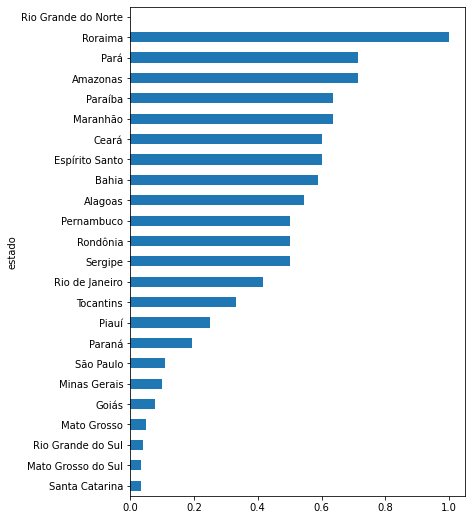

In [63]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True) & (df_h.tpGestao == 'M')]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['estado']).size() 
         / df_tmp.groupby(['estado']).size()
).sort_values().plot.barh(figsize=(6,9))

<AxesSubplot:ylabel='estado,tpGestao'>

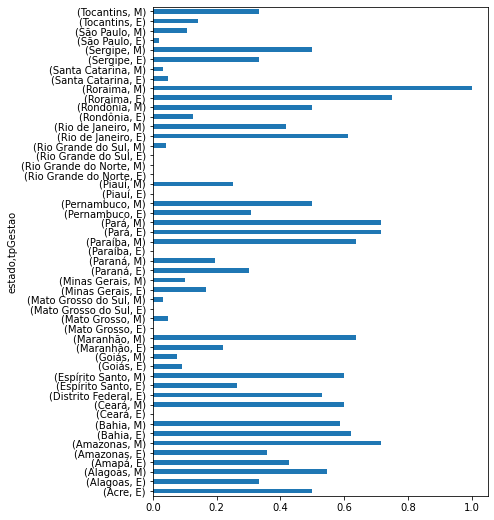

In [64]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True) & (df_h.tpGestao.isin(['M', 'E']))]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['estado', 'tpGestao']).size() 
         / df_tmp.groupby(['estado', 'tpGestao']).size()
).plot.barh(figsize=(6,9))

<AxesSubplot:ylabel='tpGestao'>

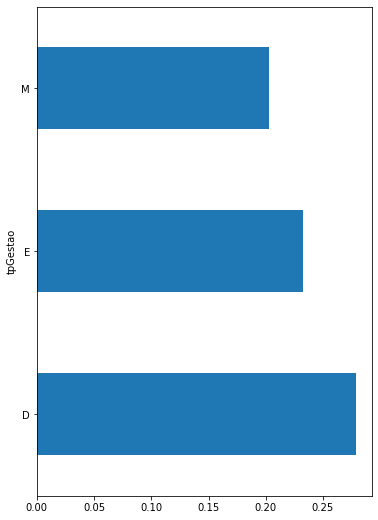

In [65]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True) & (df_h.tpGestao.isin(['M', 'E', 'D']))]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['tpGestao']).size() 
         / df_tmp.groupby(['tpGestao']).size()
).plot.barh(figsize=(6,9))

In [66]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True) & (df_h.tpGestao.isin(['M', 'E']))]

df_tmp = (df_tmp[df_tmp['updated_14d'] == False].groupby(['estado', 'tpGestao']).size() 
         / df_tmp.groupby(['estado', 'tpGestao']).size()
)

df_tmp.reset_index().groupby(['tpGestao']).mean()

,0
tpGestao,
E,0.343140
M,0.398647


## Taxa de ocupação por estado

In [67]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True)]

by_state = df_tmp.groupby('estado').agg({
    '_id': 'count',
    'totalOfertaUti': 'sum',
    'totalOfertaUtiAlt': 'sum',
    'totalOcupUti': 'sum',
    'ofertaSRAGUti': 'sum',
    'ocupSRAGUti': 'sum',
    'updated_7d': 'sum',
    'updated_14d': 'sum',
    'updated_90d': 'sum',
})

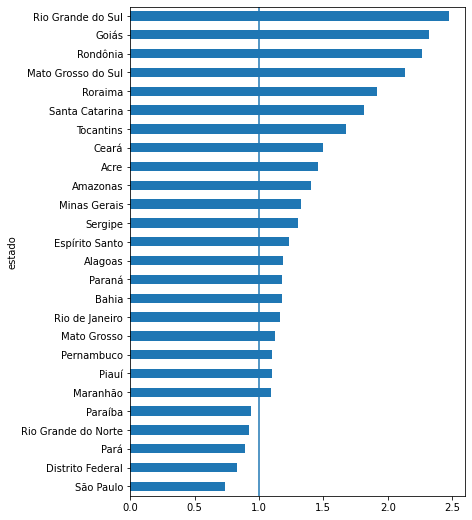

In [68]:
by_state['pct_occupied'] = by_state['totalOcupUti'] / by_state['totalOfertaUti']
by_state[by_state['pct_occupied'] < 10]['pct_occupied'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

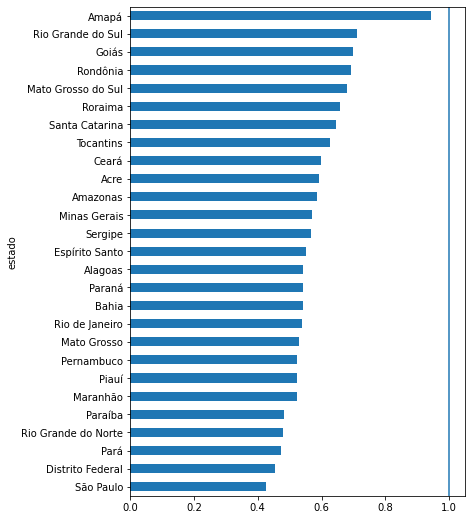

In [69]:
by_state['pct_occupied_alt'] = by_state['totalOcupUti'] / by_state['totalOfertaUtiAlt']
by_state[by_state['pct_occupied_alt'] < 10]['pct_occupied_alt'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

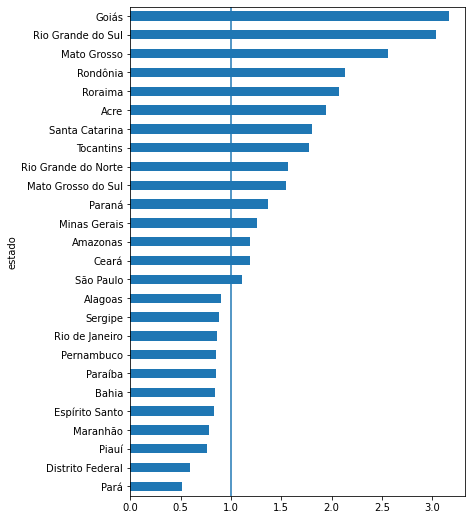

In [70]:
by_state['pct_occupied_srag'] = by_state['ocupSRAGUti'] / by_state['ofertaSRAGUti']
by_state[by_state['pct_occupied_srag'] < 10]['pct_occupied_srag'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

In [71]:
by_state

,_id,totalOfertaUti,totalOfertaUtiAlt,totalOcupUti,ofertaSRAGUti,ocupSRAGUti,updated_7d,updated_14d,updated_90d,pct_occupied,pct_occupied_alt,pct_occupied_srag
estado,,,,,,,,,,,,
Acre,2,76.0,187.0,111.0,50.0,97,1,1,2,1.460526,0.593583,1.940000
Alagoas,17,439.0,960.0,521.0,255.0,229,9,9,14,1.186788,0.542708,0.898039
Amapá,7,16.0,277.0,261.0,6.0,159,4,4,5,16.312500,0.942238,26.500000
Amazonas,25,496.0,1194.0,698.0,247.0,295,12,14,21,1.407258,0.584590,1.194332
Bahia,76,1881.0,4099.0,2218.0,1051.0,886,30,32,46,1.179160,0.541108,0.843007
Ceará,60,1536.0,3836.0,2300.0,858.0,1023,27,27,30,1.497396,0.599583,1.192308
Distrito Federal,17,687.0,1257.0,570.0,366.0,219,7,8,12,0.829694,0.453461,0.598361
Espírito Santo,30,1059.0,2363.0,1304.0,692.0,573,18,19,22,1.231350,0.551841,0.828035
Goiás,116,1451.0,4821.0,3370.0,471.0,1491,105,107,109,2.322536,0.699025,3.165605


## Leitos CNES

In [72]:
all_beds = []
for index, row in df_h[df_h['beds'].notna()].iterrows():
    beds = row['beds']
    for bed in beds:
        bed['cnes'] = row['cnes']
        all_beds.append(bed)

In [73]:
df_beds = pd.DataFrame(all_beds)
df_beds.head()

,dsAtributo,coLeito,dsLeito,qtExistente,qtSus,cnes
0,ESPEC - CIRURGICO,03,CIRURGIA GERAL,3,1,2249626
1,ESPEC - CIRURGICO,06,GINECOLOGIA,1,1,2249626
2,ESPEC - CLINICO,32,CARDIOLOGIA,2,1,2249626
3,ESPEC - CLINICO,33,CLINICA GERAL,23,10,2249626
4,OBSTETRICO,10,OBSTETRICIA CIRURGICA,1,1,2249626


In [74]:
df_beds['total_beds'] = df_beds['qtExistente'].astype(float)

In [75]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_beds[df_beds.dsLeito.str[0:3] == 'UTI'].groupby(['dsLeito', 'dsAtributo']).total_beds.sum().sort_values(ascending=False))

dsLeito                                                       dsAtributo  
UTI II ADULTO-SINDROME RESP. AGUDA GRAVE (SRAG)-COVID-19      COMPLEMENTAR    20263.0
UTI ADULTO - TIPO II                                          COMPLEMENTAR    15735.0
UTI NEONATAL - TIPO II                                        COMPLEMENTAR     4896.0
UTI ADULTO - TIPO III                                         COMPLEMENTAR     3540.0
UTI PEDIATRICA - TIPO II                                      COMPLEMENTAR     2336.0
UTI ADULTO - TIPO I                                           COMPLEMENTAR     1856.0
UTI NEONATAL - TIPO III                                       COMPLEMENTAR      882.0
UTI PEDIATRICA - TIPO III                                     COMPLEMENTAR      784.0
UTI II PEDIATRICA-SINDROME RESP. AGUDA GRAVE (SRAG)-COVID-19  COMPLEMENTAR      609.0
UTI CORONARIANA TIPO II - UCO TIPO II                         COMPLEMENTAR      540.0
UTI NEONATAL - TIPO I                                         COM

### Leitos tipo UTI

In [76]:
df_beds['uti'] = np.where(df_beds.dsLeito.str[0:3] == 'UTI', np.where(df_beds.dsLeito.str.contains('NEONATAL|QUEIMADOS') == False, True, False), False)

In [77]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_beds[df_beds.dsLeito.str[0:3] == 'UTI'].groupby(['dsLeito', 'dsAtributo', 'uti']).size().sort_values(ascending=False))

dsLeito                                                       dsAtributo    uti  
UTI II ADULTO-SINDROME RESP. AGUDA GRAVE (SRAG)-COVID-19      COMPLEMENTAR  True     1065
UTI ADULTO - TIPO II                                          COMPLEMENTAR  True      982
UTI NEONATAL - TIPO II                                        COMPLEMENTAR  False     433
UTI PEDIATRICA - TIPO II                                      COMPLEMENTAR  True      300
UTI ADULTO - TIPO I                                           COMPLEMENTAR  True      161
UTI ADULTO - TIPO III                                         COMPLEMENTAR  True      118
UTI II PEDIATRICA-SINDROME RESP. AGUDA GRAVE (SRAG)-COVID-19  COMPLEMENTAR  True       97
UTI PEDIATRICA - TIPO III                                     COMPLEMENTAR  True       71
UTI NEONATAL - TIPO III                                       COMPLEMENTAR  False      68
UTI CORONARIANA TIPO II - UCO TIPO II                         COMPLEMENTAR  True       58
UTI NEONATAL - TIP

In [78]:
cnes_uti = df_beds[df_beds['uti'] == True].groupby('cnes').agg({'total_beds': 'sum'})
cnes_uti.reset_index(inplace=True)
cnes_uti.rename(columns={'total_beds': 'uti_beds_via_cnes'}, inplace=True)
cnes_uti.head()

,cnes,uti_beds_via_cnes
0,0000396,10.0
1,0000418,70.0
2,0000426,123.0
3,0000434,143.0
4,0000477,98.0


In [79]:
df_hb = df_h.merge(cnes_uti, on='cnes', how='left')

In [80]:
df_hb.head()

,_index,_type,_id,_score,estado,estadoSigla,municipio,cnes,nomeCnes,dataNotificacaoOcupacao,...,nuCompDesab,dtCarga,dtAtualizacaoOrigem,dtAtualizacao,beds,deactivated,ts_run_cnes,error,deactivated_proxy,uti_beds_via_cnes
0,leito_ocupacao,_doc,2249626,1.0,Rio Grande do Sul,RS,Estação,2249626,HOSPITAL SANTO ANTONIO ESTACAO,2021-03-05 06:40:51+00:00,...,None,02/03/2021,17/03/2003,06/08/2019,"[{'dsAtributo': 'ESPEC - CIRURGICO', 'coLeito'...",False,2021-03-03T18:25:14.012835+00:00,False,False,NaN
1,leito_ocupacao,_doc,2338386,1.0,Goiás,GO,Goiânia,2338386,FUNDACAO BANCO DE OLHOS DE GOIAS,2021-03-05 11:21:37+00:00,...,None,01/03/2021,30/10/2001,05/11/2020,"[{'dsAtributo': 'ESPEC - CIRURGICO', 'coLeito'...",False,2021-03-03T18:25:14.012835+00:00,False,False,NaN
2,leito_ocupacao,_doc,2384035,1.0,Goiás,GO,Santa Rosa de Goiás,2384035,HOSPITAL MUNICIPAL DE SANTA ROSA DE GOIAS,2021-03-05 07:54:52+00:00,...,None,25/02/2021,24/06/2003,09/02/2021,"[{'dsAtributo': 'ESPEC - CIRURGICO', 'coLeito'...",False,2021-03-03T18:25:14.012835+00:00,False,False,NaN
3,leito_ocupacao,_doc,2519356,1.0,Goiás,GO,Goiânia,2519356,MATERNIDADE MODELO,2021-03-05 09:13:53+00:00,...,None,01/03/2021,12/03/2002,05/04/2019,"[{'dsAtributo': 'ESPEC - CIRURGICO', 'coLeito'...",False,2021-03-03T18:25:14.012835+00:00,False,False,NaN
4,leito_ocupacao,_doc,2664836,1.0,Goiás,go,Goiânia,2664836,NaN,2021-03-05 09:03:19+00:00,...,None,01/03/2021,08/04/2003,25/07/2019,[],False,2021-03-03T18:25:14.012835+00:00,False,False,NaN


In [81]:
df_hb.columns.values

array(['_index', '_type', '_id', '_score', 'estado', 'estadoSigla',
       'municipio', 'cnes', 'nomeCnes', 'dataNotificacaoOcupacao',
       'ofertaRespiradores', 'ofertaHospCli', 'ofertaHospUti',
       'ofertaSRAGCli', 'ofertaSRAGUti', 'ocupHospCli', 'ocupHospUti',
       'ocupSRAGCli', 'ocupSRAGUti', 'altas', 'obitos',
       'ocupacaoInformada', 'algumaOcupacaoInformada', 'ts_run',
       'totalOfertaCli', 'totalOfertaUti', 'totalOcupCli', 'totalOcupUti',
       'totalOfertaCliAlt', 'totalOfertaUtiAlt', 'has_uti_proxy',
       'updated_7d', 'updated_14d', 'updated_90d', 'id', 'noFantasia',
       'noEmpresarial', 'natJuridica', 'natJuridicaMant', 'cnpj',
       'tpPessoa', 'nvDependencia', 'nuAlvara', 'dtExpAlvara',
       'orgExpAlvara', 'dsTpUnidade', 'dsStpUnidade', 'noLogradouro',
       'nuEndereco', 'cep', 'regionalSaude', 'bairro', 'noComplemento',
       'municipio_cnes', 'noMunicipio', 'uf', 'tpGestao', 'nuTelefone',
       'tpSempreAberto', 'coMotivoDesab', 'dsMotivoDesa

In [82]:
df_hb['bed_diff'] = df_hb['totalOfertaUti'] - df_hb['uti_beds_via_cnes']
df_hb['bed_diff_alt'] = df_hb['totalOfertaUtiAlt'] - df_hb['uti_beds_via_cnes']

count    1534.000000
mean       -4.495437
std        18.082500
min      -178.000000
25%       -10.000000
50%        -1.000000
75%         0.000000
max       280.000000
Name: bed_diff, dtype: float64


<AxesSubplot:>

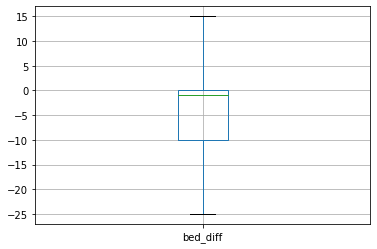

In [83]:
print(df_hb['bed_diff'].describe())
df_hb[['bed_diff']].boxplot(showfliers=False)

count    1534.000000
mean       25.641460
std        40.467964
min       -60.000000
25%         4.000000
50%        15.000000
75%        34.000000
max       435.000000
Name: bed_diff_alt, dtype: float64


<AxesSubplot:>

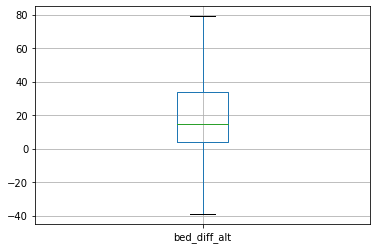

In [84]:
print(df_hb['bed_diff_alt'].describe())
df_hb[['bed_diff_alt']].boxplot(showfliers=False)

In [85]:
df_tmp = df_hb[(df_hb['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True)]

by_state = df_tmp.groupby('estado').agg({
    '_id': 'count',
    'uti_beds_via_cnes': 'sum',
    'totalOfertaUti': 'sum',
    'totalOfertaUtiAlt': 'sum',
    'totalOcupUti': 'sum',
    'ofertaSRAGUti': 'sum',
    'ocupSRAGUti': 'sum',
    'ofertaHospUti': 'sum',
    'ocupHospUti': 'sum',
    'updated_7d': 'sum',
    'updated_14d': 'sum',
    'updated_90d': 'sum',
})

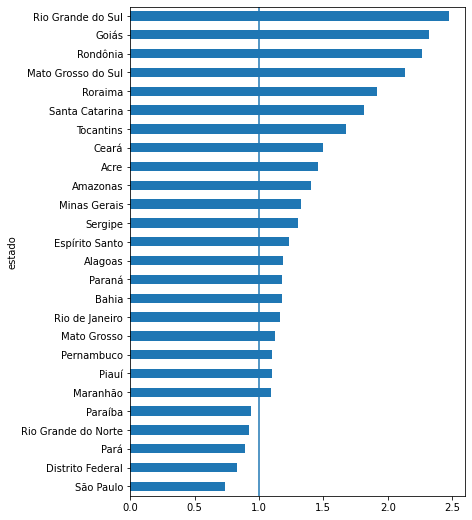

In [86]:
by_state['pct_occupied'] = by_state['totalOcupUti'] / by_state['totalOfertaUti']
by_state[by_state['pct_occupied'] < 10]['pct_occupied'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

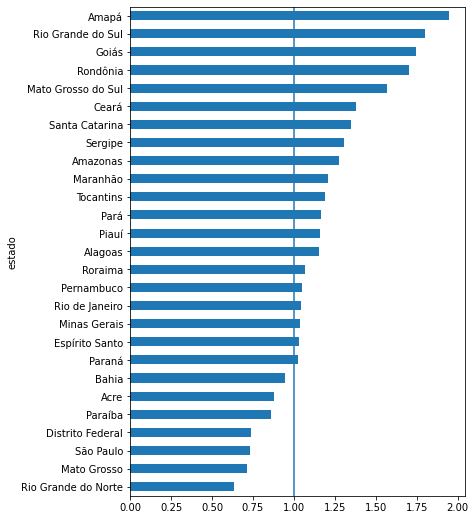

In [87]:
by_state['pct_occupied_cnes'] = by_state['totalOcupUti'] / by_state['uti_beds_via_cnes']
by_state[by_state['pct_occupied_cnes'] < 10]['pct_occupied_cnes'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

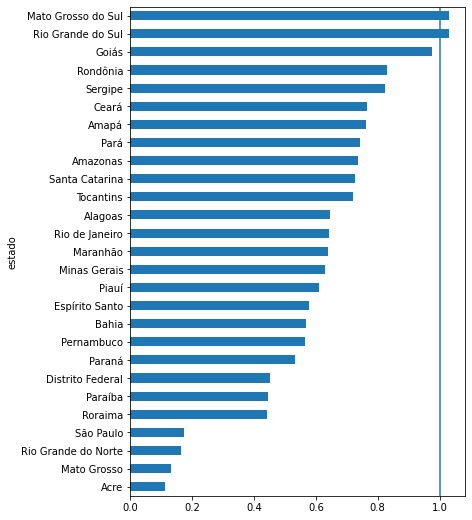

In [88]:
by_state['pct_occupied_cnes_hosp'] = by_state['ocupHospUti'] / by_state['uti_beds_via_cnes']
by_state[by_state['pct_occupied_cnes_hosp'] < 10]['pct_occupied_cnes_hosp'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

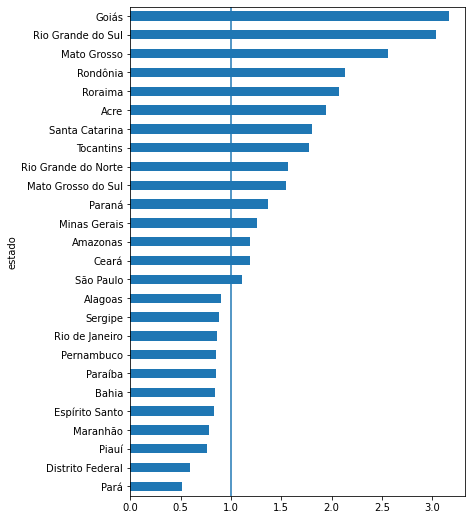

In [89]:
by_state['pct_occupied_srag'] = by_state['ocupSRAGUti'] / by_state['ofertaSRAGUti']
by_state[by_state['pct_occupied_srag'] < 10]['pct_occupied_srag'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

In [91]:
by_state[10:]

,_id,uti_beds_via_cnes,totalOfertaUti,totalOfertaUtiAlt,totalOcupUti,ofertaSRAGUti,ocupSRAGUti,ofertaHospUti,ocupHospUti,updated_7d,updated_14d,updated_90d,pct_occupied,pct_occupied_cnes,pct_occupied_cnes_hosp,pct_occupied_srag
estado,,,,,,,,,,,,,,,,
Mato Grosso,55,1064.0,672.0,1429.0,757.0,241.0,617,431.0,140.0,53,53,54,1.126488,0.711466,0.131579,2.560166
Mato Grosso do Sul,33,749.0,550.0,1723.0,1173.0,259.0,401,291.0,772.0,31,32,33,2.132727,1.566088,1.030708,1.548263
Minas Gerais,197,5295.0,4158.0,9662.0,5504.0,1729.0,2169,2429.0,3335.0,171,176,186,1.323713,1.039471,0.629839,1.254482
Paraná,81,2748.0,2381.0,5192.0,2811.0,989.0,1349,1392.0,1462.0,55,60,70,1.180596,1.022926,0.532023,1.364004
Paraíba,19,535.0,491.0,950.0,459.0,259.0,220,232.0,239.0,7,10,11,0.934827,0.857944,0.446729,0.849421
Pará,31,676.0,882.0,1669.0,787.0,548.0,284,334.0,503.0,6,9,12,0.892290,1.164201,0.744083,0.518248
Pernambuco,53,1887.0,1794.0,3771.0,1977.0,1067.0,911,727.0,1066.0,30,33,41,1.102007,1.047695,0.564918,0.853796
Piauí,16,353.0,372.0,781.0,409.0,253.0,194,119.0,215.0,11,13,15,1.099462,1.158640,0.609065,0.766798
Rio Grande do Norte,42,834.0,573.0,1100.0,527.0,250.0,391,323.0,136.0,38,38,39,0.919721,0.631894,0.163070,1.564000


CREATE EXTERNAL TABLE IF NOT EXISTS datalake_medidasp.leitos (
  hits:array<struct<
    `_index`:string,
    `_type`:string,
    `_id`:string,
    `_score`:string,
    `_source.estado`:string,
    `_source.estadosigla`:string,
    `_source.municipio`:string,
    `_source.cnes`:string,
    `_source.nomecnes`:string,
    `_source.datanotificacaoocupacao`:string,
    `_source.ofertarespiradores`:string,
    `_source.ofertahospcli`:string,
    `_source.ofertahosputi`:string,
    `_source.ofertasragcli`:string,
    `_source.ofertasraguti`:string,
    `_source.ocuphospcli`:string,
    `_source.ocuphosputi`:string,
    `_source.ocupsragcli`:string,
    `_source.ocupsraguti`:string,
    `_source.altas`:string,
    `_source.obitos`:string,
    `_source.ocupacaoinformada`:string,
    `_source.algumaocupacaoinformada`:string>> 
)
ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
WITH SERDEPROPERTIES (
  'serialization.format' = '1'
) LOCATION 's3://medidasp/leitos/'
TBLPROPERTIES ('has_encrypted_data'='false');